#  Analyze calculated edge circadian score 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

Edge circadian score = (all importance score for paths that traverse circadian genes)/(all importance scores for paths that traverse genes)

Circadian genes: amplitude >= 0.1, FDR < 0.05 (used in Ruben et al, STM 2018 paper)

We calculated edge circadian score for drug-disease pairs from two datasets: 

1. Ruben et al dataset that contains drug-disease pairs evaluated by clinical trials in terms of time-of-administration (circadian efficacy or none)

2. Indication dataset that contains drug-disease pairs from hetionet. Drugs were filtered by half-life < 24hrs

In [2]:
# read in edge circadian scores of Ruben et al dataset
ruben_score_df = pd.read_csv('data/HumCircMed2018v2_mapped_edge_circa_scores.tsv', header = 0, sep = '\t')
ruben_score_df.head(2)

,drug.trtmnt,drug.trtmnt_drugbank_id,therapeutic.area,therapeutic.area_doid,halflife.hrs,effect,Aorta,Artery Coronary,Artery Tibial,Colon,...,Fat Visceral,Heart Atrial,Liver,Lung,Nerve Tibial,Pituitary,Thyroid,score_note,metapath_cout,path_cout
0,prednisone,DB00635,asthma,DOID:2841,2.5,more eff,0.0347,0.1573,0.0102,0.0451,...,0.2394,0.2420,0.0865,0.0101,0.0303,0.008,0.1218,NaN,1.0,145.0
1,theophylline,DB00277,asthma,DOID:2841,8.0,more eff,0.0000,0.2210,0.0000,0.0000,...,0.0009,0.0435,0.0000,0.0000,0.0000,0.000,0.2017,NaN,4.0,41.0


In [3]:
# read in edge circadian score of indication dataset
indi_score_df = pd.read_csv('data/indication_edge_circa_scores.tsv', header = 0, sep = '\t')
indi_score_df.head(2)

,compound_id,compound_name,disease_id,disease_name,rel_type,half_life_hours_curated,Aorta,Artery Coronary,Artery Tibial,Colon,...,Fat Visceral,Heart Atrial,Liver,Lung,Nerve Tibial,Pituitary,Thyroid,score_note,metapath_cout,path_cout
0,DB01048,Abacavir,DOID:635,acquired immunodeficiency syndrome,TREATS_CtD,1.54,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,1.0
1,DB05812,Abiraterone,DOID:10283,prostate cancer,TREATS_CtD,9.50,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,query drug and disease connected by genes not ...,1,0.0


### Score statistics of Ruben et al data 

In [4]:
# Number of drug-disease pairs
len(ruben_score_df)

52

In [5]:
# Score cannot be calculated for some drug~disease pairs due to various reasons
ruben_score_df['score_note'].value_counts()

query disease not in hetionet                                12
query drug and disease connected by genes not in CircaDB     11
query drug and disease not connected by genes in hetionet     6
Name: score_note, dtype: int64

In [6]:
# Some drug-disease pairs have other effect annotation than 'more eff' or 'none'
ruben_score_df['effect'].value_counts()

more eff                        35
none                            14
more eff/better tolerability     2
more eff / less Aes              1
Name: effect, dtype: int64

In [7]:
ruben_score_df['effect'] = ruben_score_df.effect.str.replace('more eff/better tolerability','more eff')
ruben_score_df['effect'] = ruben_score_df.effect.str.replace('more eff / less Aes','more eff')

In [8]:
# Number of drug-disease pairs of which the score can be calculated
ruben_score_df = ruben_score_df[~ruben_score_df.Aorta.isna()]
len(ruben_score_df)

23

In [9]:
# Some drug-disease pairs have two few path (>=5) between them. Filter out such pairs.
ruben_score_df = ruben_score_df[ruben_score_df.path_cout >= 5]
len(ruben_score_df)

20

In [10]:
# Number of positive and negative pairs
ruben_score_df['effect'].value_counts()

more eff    13
none         7
Name: effect, dtype: int64

### Score statistics of indication data

In [11]:
# Number of drug-disease pairs
len(indi_score_df)

377

In [12]:
# Score cannot be calculated for some drug~disease pairs due to various reasons
indi_score_df['score_note'].value_counts()

query drug and disease connected by genes not in CircaDB     52
query drug and disease not connected by genes in hetionet    42
Name: score_note, dtype: int64

In [13]:
# Number of drug-disease pairs of which the score can be calculated
indi_score_df = indi_score_df[~indi_score_df.Aorta.isna()]
len(indi_score_df)

283

In [14]:
# Some drug-disease pairs have two few path (>=5) between them. Filter out such pairs.
indi_score_df = indi_score_df[indi_score_df.path_cout >= 5]
len(indi_score_df)

207

### Score distribution of all drug-disease pairs

Aggregate dataframes of scores from two datasets. 

In [15]:
# select columns to be included in the combined dataframe: indication dataset
indi_select_col = ['compound_id','disease_id','half_life_hours_curated','Aorta',
                   'Artery Coronary','Artery Tibial','Colon','Esophagus','Fat SQ','Fat Visceral','Heart Atrial',
                   'Liver','Lung','Nerve Tibial','Pituitary','Thyroid','metapath_cout','path_cout']
indi_score_subset = indi_score_df[indi_select_col]
len(indi_score_subset)

207

In [16]:
# select columns to be included in the combined dataframe: Ruben et al dataset
ruben_select_col = ['drug.trtmnt_drugbank_id','therapeutic.area_doid','halflife.hrs',
                    'Aorta','Artery Coronary','Artery Tibial','Colon','Esophagus','Fat SQ','Fat Visceral',
                    'Heart Atrial','Liver','Lung','Nerve Tibial','Pituitary','Thyroid','metapath_cout','path_cout']
ruben_score_subset = pd.DataFrame.drop_duplicates(ruben_score_df[ruben_select_col])
ruben_score_subset.columns = indi_select_col
len(ruben_score_subset)

13

In [17]:
# combine two dataframes
score_df = pd.concat([ruben_score_subset, indi_score_subset])
score_df = pd.DataFrame.drop_duplicates(score_df)
len(score_df)

216

In [18]:
score_df.head()

,compound_id,disease_id,half_life_hours_curated,Aorta,Artery Coronary,Artery Tibial,Colon,Esophagus,Fat SQ,Fat Visceral,Heart Atrial,Liver,Lung,Nerve Tibial,Pituitary,Thyroid,metapath_cout,path_cout
0,DB00635,DOID:2841,2.50,0.0347,0.1573,0.0102,0.0451,0.1221,0.0000,0.2394,0.2420,0.0865,0.0101,0.0303,0.008,0.1218,1.0,145.0
1,DB00277,DOID:2841,8.00,0.0000,0.2210,0.0000,0.0000,0.2851,0.0009,0.0009,0.0435,0.0000,0.0000,0.0000,0.000,0.2017,4.0,41.0
2,DB00668,DOID:2841,0.03,0.0775,0.1794,0.0000,0.0000,0.5312,0.0000,0.1404,0.0581,0.2737,0.0000,0.0136,0.000,0.0136,2.0,19.0
9,DB00635,DOID:7148,2.50,0.0000,0.2100,0.0362,0.0492,0.1793,0.0080,0.1145,0.2440,0.0253,0.0000,0.0457,0.000,0.0191,2.0,201.0
10,DB00712,DOID:7148,5.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.000,0.0000,1.0,12.0


Boxplot showing the distribution of edge circadian scores in 13 tissues

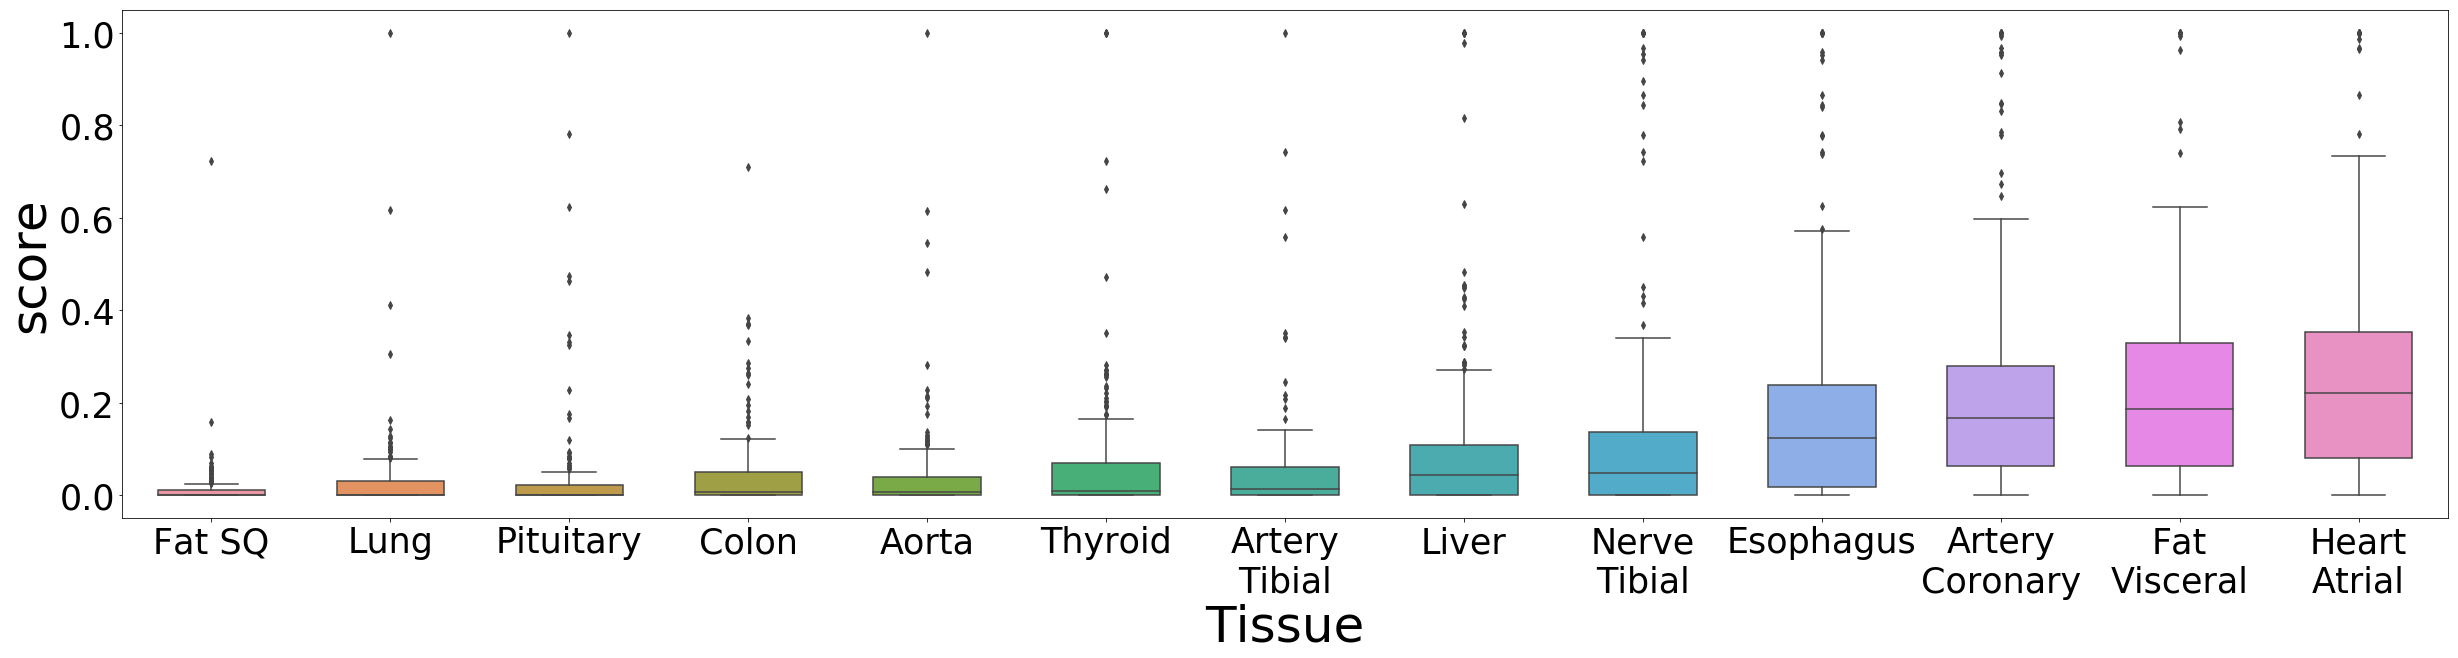

In [19]:
# Some tissue names are too long. 
# Rename those columns using '\n' so that the names can be appropriately displayed in boxplot
score_df.columns = ['compound_id','disease_id','half_life_hours_curated','Aorta',
                   'Artery\nCoronary','Artery\nTibial','Colon','Esophagus','Fat SQ','Fat\nVisceral','Heart\nAtrial',
                   'Liver','Lung','Nerve\nTibial','Pituitary','Thyroid','Metapath cout','Path cout']

# plot score distribution in 13 tissues by sorted order (median from lowest to highest)
tissues = ['Aorta','Artery\nCoronary','Artery\nTibial','Colon','Esophagus','Fat SQ','Fat\nVisceral','Heart\nAtrial',
           'Liver','Lung','Nerve\nTibial','Pituitary','Thyroid']
sort_tissues = list(score_df[tissues].median().sort_values().index)
score_melt_df = pd.melt(score_df, value_vars = sort_tissues)

plt.figure(figsize = (35,10))
sns.despine(left = True)
plt.rc('font', size = 35)
plt.rc('axes', titlesize = 35)
plt.rc('axes', labelsize = 35)
plt.rc('xtick', labelsize = 35)
plt.rc('ytick', labelsize = 35)
plt.rc('legend', fontsize = 35)

ax = sns.boxplot(x = 'variable', y = 'value', data = score_melt_df, width = 0.6)
ax.set_xlabel('Tissue', size = 50)
ax.set_ylabel('score', size = 50)
plt.tight_layout()
plt.savefig('plot/edge_circa_score_distribution.pdf')

plt.show()

Histagram showing the distribution of metapath count and path count

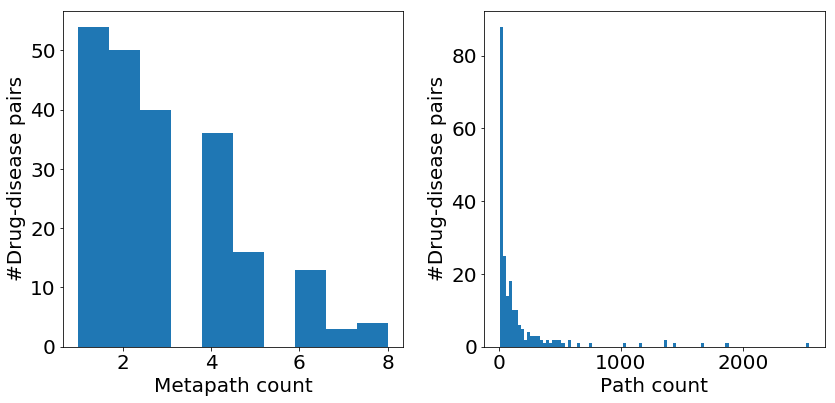

In [20]:
# plot half-life ~ score 
plt.figure(figsize = (12,6))
sns.despine(left = True)
plt.rc('font', size = 20)
plt.rc('axes', titlesize = 20)
plt.rc('axes', labelsize = 20)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
plt.rc('legend', fontsize = 20)

# Metapath count
ax = plt.subplot(1, 2, 1)
axh = ax.hist(score_df['Metapath cout'])
ax.set_xlabel('Metapath count', size = 20)
ax.set_ylabel('#Drug-disease pairs', size= 20)

# amplitude
ax = plt.subplot(1, 2, 2)
axh = ax.hist(score_df['Path cout'], bins = 100)
ax.set_xlabel('Path count', size = 20)
ax.set_ylabel('#Drug-disease pairs', size= 20)

plt.tight_layout()
plt.show()

Scatterplot showing the correlation bewteen edge circadian score and log half-life of drug

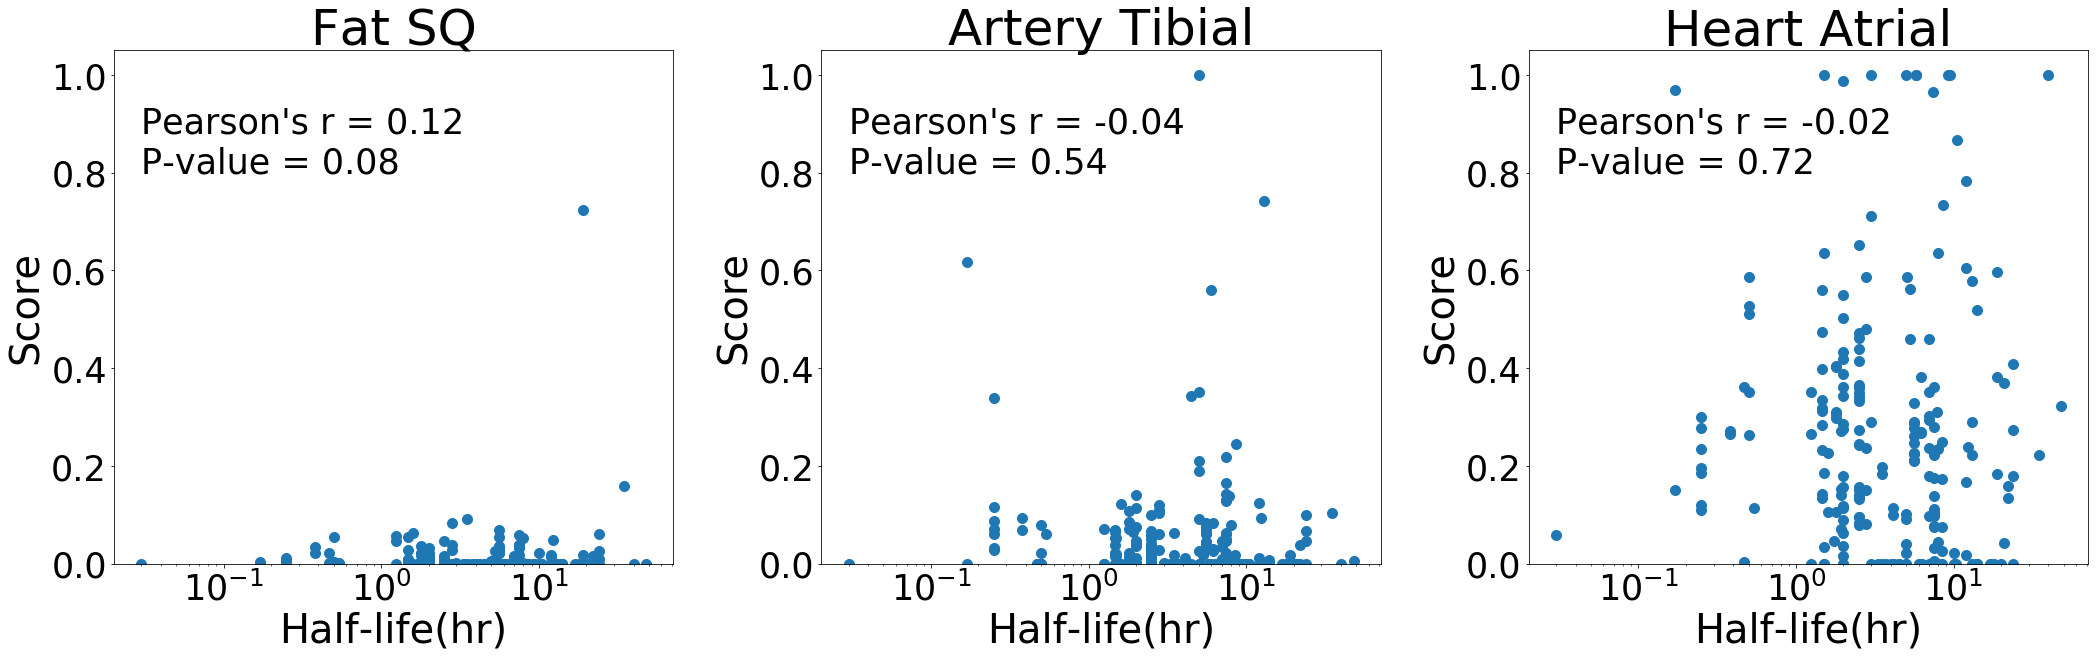

In [21]:
# select three tissues by median (lowest, medium, highest)
plot_tissues = ['Fat SQ','Artery\nTibial','Heart\nAtrial']
plot_tissue_names = ['Fat SQ','Artery Tibial','Heart Atrial']

# plot half-life ~ score 
plt.figure(figsize = (30,10))
sns.despine(left = True)
plt.rc('font', size = 35)
plt.rc('axes', titlesize = 35)
plt.rc('axes', labelsize = 35)
plt.rc('xtick', labelsize = 35)
plt.rc('ytick', labelsize = 35)
plt.rc('legend', fontsize = 25)

for i in range(0, len(plot_tissues)):
    # pearson correlation coefficient between score and half-life(log)
    pcc = scipy.stats.pearsonr(np.log10(score_df['half_life_hours_curated']), score_df[plot_tissues[i]])

    axi = plt.subplot(1, len(plot_tissues), i+1)
    score_df.plot(x = 'half_life_hours_curated', y = plot_tissues[i], kind = 'scatter', logx = True, 
                  s = 100, ax = axi)
    axi.set_ylim(0, 1.05)
    axi.set_title(plot_tissue_names[i], size = 50)
    axi.set_xlabel('Half-life(hr)', size = 40)
    axi.set_ylabel('Score', size= 40)

    # pearson correlation coefficient between score and half-life(log)
    pcc = scipy.stats.pearsonr(np.log10(score_df['half_life_hours_curated']), score_df[plot_tissues[i]])
    pcc_text = 'Pearson\'s r = ' + ('%.2f' % pcc[0]) + '\n' + 'P-value = ' + ('%.2f' % pcc[1])
    plt.text(0.03, 0.8, pcc_text)
            
plt.tight_layout()
plt.savefig('plot/edge_circa_score_halflife.pdf')

plt.show()

### Edge circadian score in diseases of interest

Scatterplot showing scores of drugs that treat a particular disease (y-axis) and log half-life of drugs (x-axis).

Scores in four tissues are shown here: Fat Visceral (adipose), Heart Atrial (cardio), Liver (metabolic), Pituitary (nervous). 

Drugs in the Ruben et al dataset are colored in red (circadian efficacy) or blue (none). Other drugs are colored in white with black edge.

In [22]:
def visuallize_disease_score(score_df, ruben_score_df, disease_doid, plot_tissues, plot_tissue_names, save_file):
    '''
    '''
    disease_df = score_df[score_df.disease_id == disease_doid]
    ruben_disease_df = ruben_score_df[ruben_score_df['therapeutic.area_doid'] == disease_doid]
    pos_drugs = list(ruben_disease_df['drug.trtmnt_drugbank_id'][ruben_disease_df['effect'] == 'more eff'])
    neg_drugs = list(ruben_disease_df['drug.trtmnt_drugbank_id'][ruben_disease_df['effect'] == 'none'])

    pos_row = []
    neg_row = []
    for i in range(0, len(disease_df)):
        if disease_df.compound_id.iloc[i,] in pos_drugs:
            pos_row.append(i)
        elif disease_df.compound_id.iloc[i,] in neg_drugs:
            neg_row.append(i)
        else:
            continue

    for j in range(0, len(plot_tissues)):
        axj = plt.subplot(1, len(plot_tissues), j+1)
        disease_df.plot(x = 'half_life_hours_curated', y = plot_tissues[j], kind = 'scatter', 
                   logx = True, c = 'white', s = 200, ax = axj, edgecolors = 'black')
        if len(pos_row) > 0:
            disease_df.iloc[pos_row,:].plot(x = 'half_life_hours_curated', y = plot_tissues[j], kind = 'scatter', 
                   logx = True, c = 'red', s = 200, ax = axj)
        if len(neg_row) > 0:
            disease_df.iloc[neg_row,:].plot(x = 'half_life_hours_curated', y = plot_tissues[j], kind = 'scatter', 
                   logx = True, c = 'blue', s = 200, ax = axj)
        
        axj.set_xlim(0.01, 50)
        axj.set_ylim(-0.02, 1.05)
        axj.set_title(plot_tissue_names[j], size = 50)
        axj.set_xlabel('Half-life(hr)', size = 40)
        axj.set_ylabel('Score', size = 40)

    plt.tight_layout()
    plt.savefig(save_file)
    plt.show()
    
    return disease_df

#### Asthma

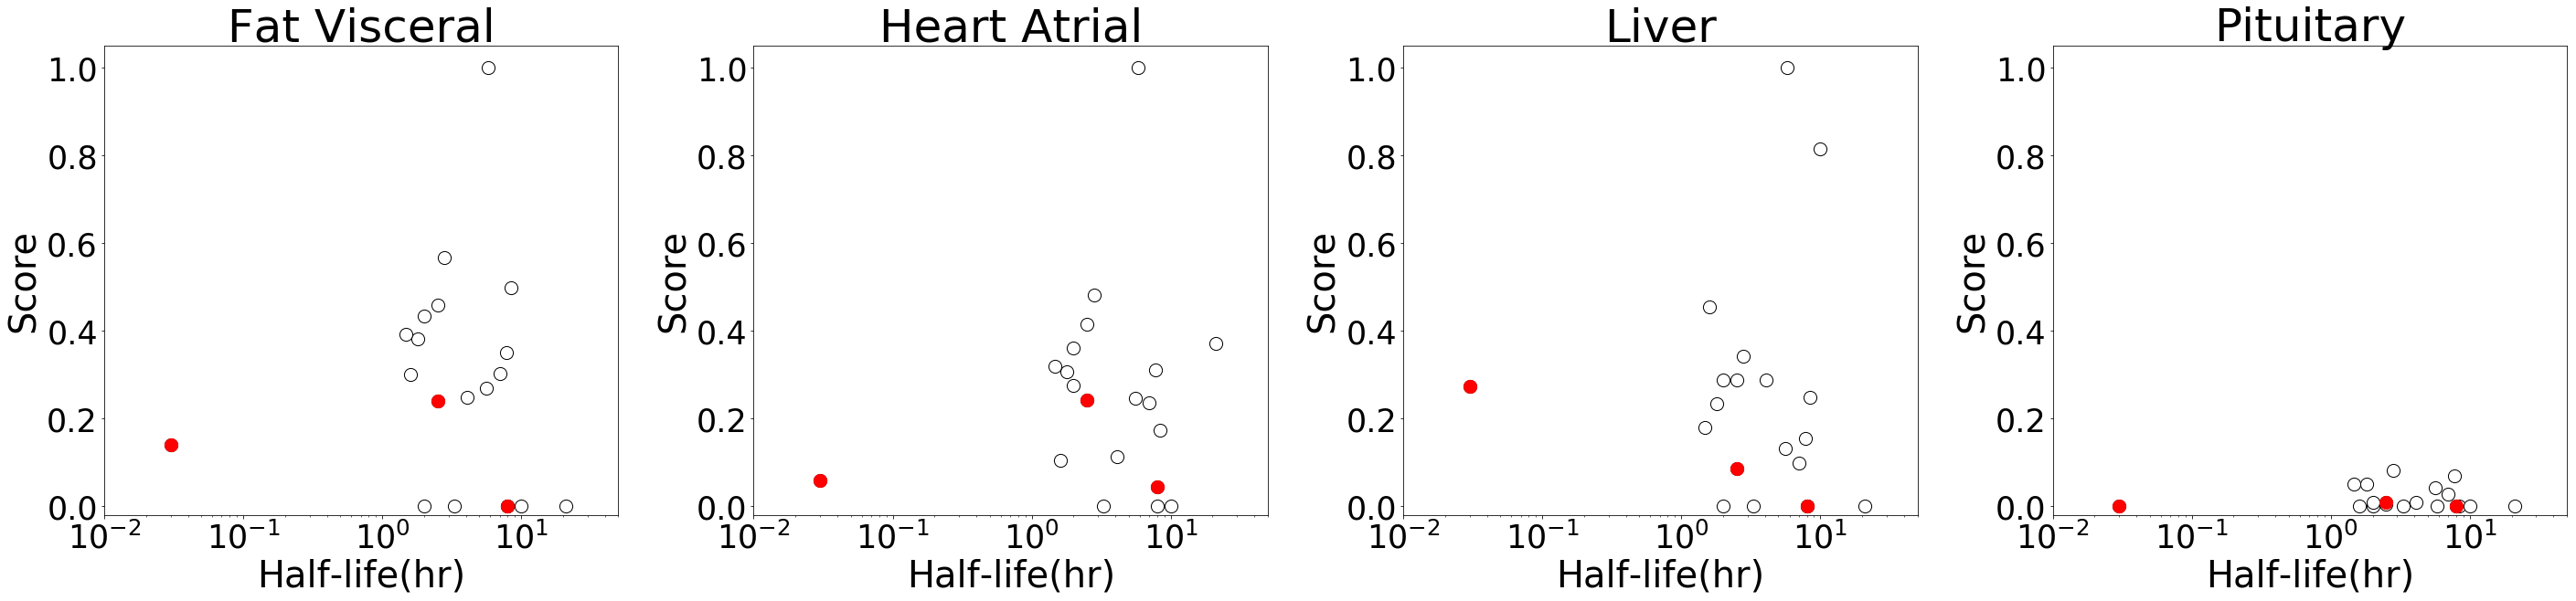

20

In [23]:
# asthma
plt.figure(figsize = (40,10))
sns.despine(left = True)
plt.rc('font', size = 35)
plt.rc('axes', titlesize = 35)
plt.rc('axes', labelsize = 35)
plt.rc('xtick', labelsize = 35)
plt.rc('ytick', labelsize = 35)
plt.rc('legend', fontsize = 25)

plot_tissues = ['Fat\nVisceral','Heart\nAtrial','Liver','Pituitary']
plot_tissue_names = ['Fat Visceral','Heart Atrial','Liver','Pituitary']
asthma_df = visuallize_disease_score(score_df, ruben_score_df, 'DOID:2841', plot_tissues, plot_tissue_names, 
                         'plot/edge_circa_score_halflife_asthma.pdf')
len(asthma_df)

In [24]:
asthma_df

,compound_id,disease_id,half_life_hours_curated,Aorta,Artery Coronary,Artery Tibial,Colon,Esophagus,Fat SQ,Fat Visceral,Heart Atrial,Liver,Lung,Nerve Tibial,Pituitary,Thyroid,Metapath cout,Path cout
0,DB00635,DOID:2841,2.50,0.0347,0.1573,0.0102,0.0451,0.1221,0.0000,0.2394,0.2420,0.0865,0.0101,0.0303,0.0080,0.1218,1.0,145.0
1,DB00277,DOID:2841,8.00,0.0000,0.2210,0.0000,0.0000,0.2851,0.0009,0.0009,0.0435,0.0000,0.0000,0.0000,0.0000,0.2017,4.0,41.0
2,DB00668,DOID:2841,0.03,0.0775,0.1794,0.0000,0.0000,0.5312,0.0000,0.1404,0.0581,0.2737,0.0000,0.0136,0.0000,0.0136,2.0,19.0
9,DB01223,DOID:2841,8.00,0.0000,0.0203,0.0000,0.0000,0.3249,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0,13.0
15,DB00394,DOID:2841,2.80,0.1115,0.5049,0.1092,0.1084,0.5112,0.0000,0.5668,0.4807,0.3419,0.0825,0.2777,0.0810,0.2709,3.0,167.0
22,DB00443,DOID:2841,5.60,0.0894,0.2486,0.0744,0.0744,0.2571,0.0207,0.2697,0.2459,0.1322,0.0704,0.1667,0.0407,0.1026,4.0,745.0
91,DB00651,DOID:2841,2.00,0.0000,0.2104,0.0000,0.2758,0.5709,0.0000,0.0000,0.2758,0.0000,0.0000,0.0000,0.0000,0.2104,2.0,12.0
118,DB00180,DOID:2841,1.80,0.0685,0.3710,0.1073,0.0501,0.3545,0.0063,0.3812,0.3067,0.2339,0.0385,0.2060,0.0506,0.1642,4.0,289.0
130,DB00588,DOID:2841,7.80,0.1259,0.3764,0.1392,0.0537,0.3560,0.0000,0.3506,0.3102,0.1547,0.1048,0.1373,0.0691,0.1235,4.0,340.0
156,DB00741,DOID:2841,7.00,0.0221,0.2748,0.0459,0.0476,0.2409,0.0000,0.3027,0.2360,0.0975,0.0120,0.0442,0.0279,0.0471,3.0,214.0


#### Rheumatoid arthritis

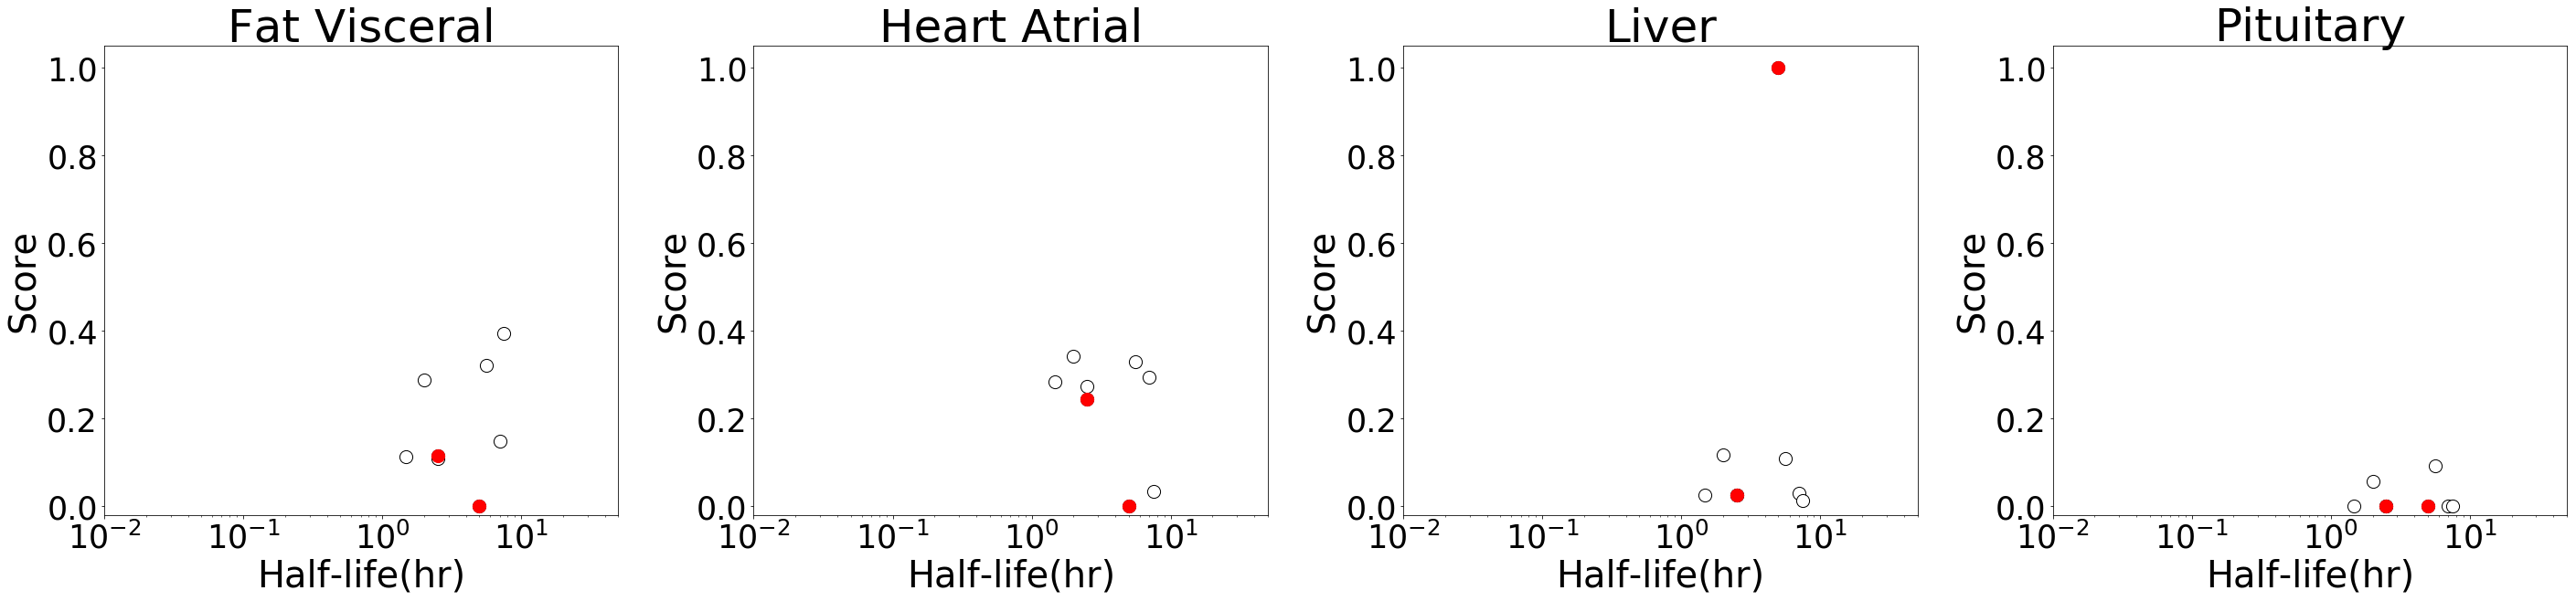

8

In [25]:
# Rheumatoid arthritis
plt.figure(figsize = (40,10))
sns.despine(left = True)
plt.rc('font', size = 35)
plt.rc('axes', titlesize = 35)
plt.rc('axes', labelsize = 35)
plt.rc('xtick', labelsize = 35)
plt.rc('ytick', labelsize = 35)
plt.rc('legend', fontsize = 25)

plot_tissues = ['Fat\nVisceral','Heart\nAtrial','Liver','Pituitary']
plot_tissue_names = ['Fat Visceral','Heart Atrial','Liver','Pituitary']
arthritis_df = visuallize_disease_score(score_df, ruben_score_df, 'DOID:7148', plot_tissues, plot_tissue_names,
                        'plot/edge_circa_score_halflife_arthritis.pdf')
len(arthritis_df)

In [26]:
arthritis_df

,compound_id,disease_id,half_life_hours_curated,Aorta,Artery Coronary,Artery Tibial,Colon,Esophagus,Fat SQ,Fat Visceral,Heart Atrial,Liver,Lung,Nerve Tibial,Pituitary,Thyroid,Metapath cout,Path cout
9,DB00635,DOID:7148,2.50,0.0000,0.2100,0.0362,0.0492,0.1793,0.0080,0.1145,0.2440,0.0253,0.0000,0.0457,0.0000,0.0191,2.0,201.0
10,DB00712,DOID:7148,5.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0,12.0
27,DB00443,DOID:7148,5.60,0.1176,0.2685,0.0836,0.1520,0.3132,0.0544,0.3215,0.3296,0.1087,0.1011,0.1416,0.0926,0.1505,8.0,1360.0
160,DB00741,DOID:7148,7.00,0.0000,0.3166,0.0000,0.0588,0.2205,0.0144,0.1481,0.2934,0.0287,0.0000,0.0705,0.0000,0.0354,1.0,95.0
214,DB00959,DOID:7148,2.00,0.0000,0.4310,0.0470,0.0535,0.1768,0.0073,0.2869,0.3421,0.1165,0.0000,0.0356,0.0573,0.0752,4.0,132.0
272,DB00860,DOID:7148,2.50,0.0000,0.2572,0.0508,0.0656,0.1627,0.0079,0.1081,0.2736,0.0244,0.0000,0.0467,0.0000,0.0342,2.0,165.0
323,DB00795,DOID:7148,7.50,0.0000,0.0305,0.0459,0.1209,0.0367,0.0000,0.3935,0.0324,0.0129,0.0000,0.0127,0.0000,0.0000,5.0,50.0
365,DB00620,DOID:7148,1.47,0.0000,0.2635,0.0526,0.0680,0.1684,0.0082,0.1119,0.2833,0.0253,0.0000,0.0484,0.0000,0.0261,1.0,157.0


#### Hypertension

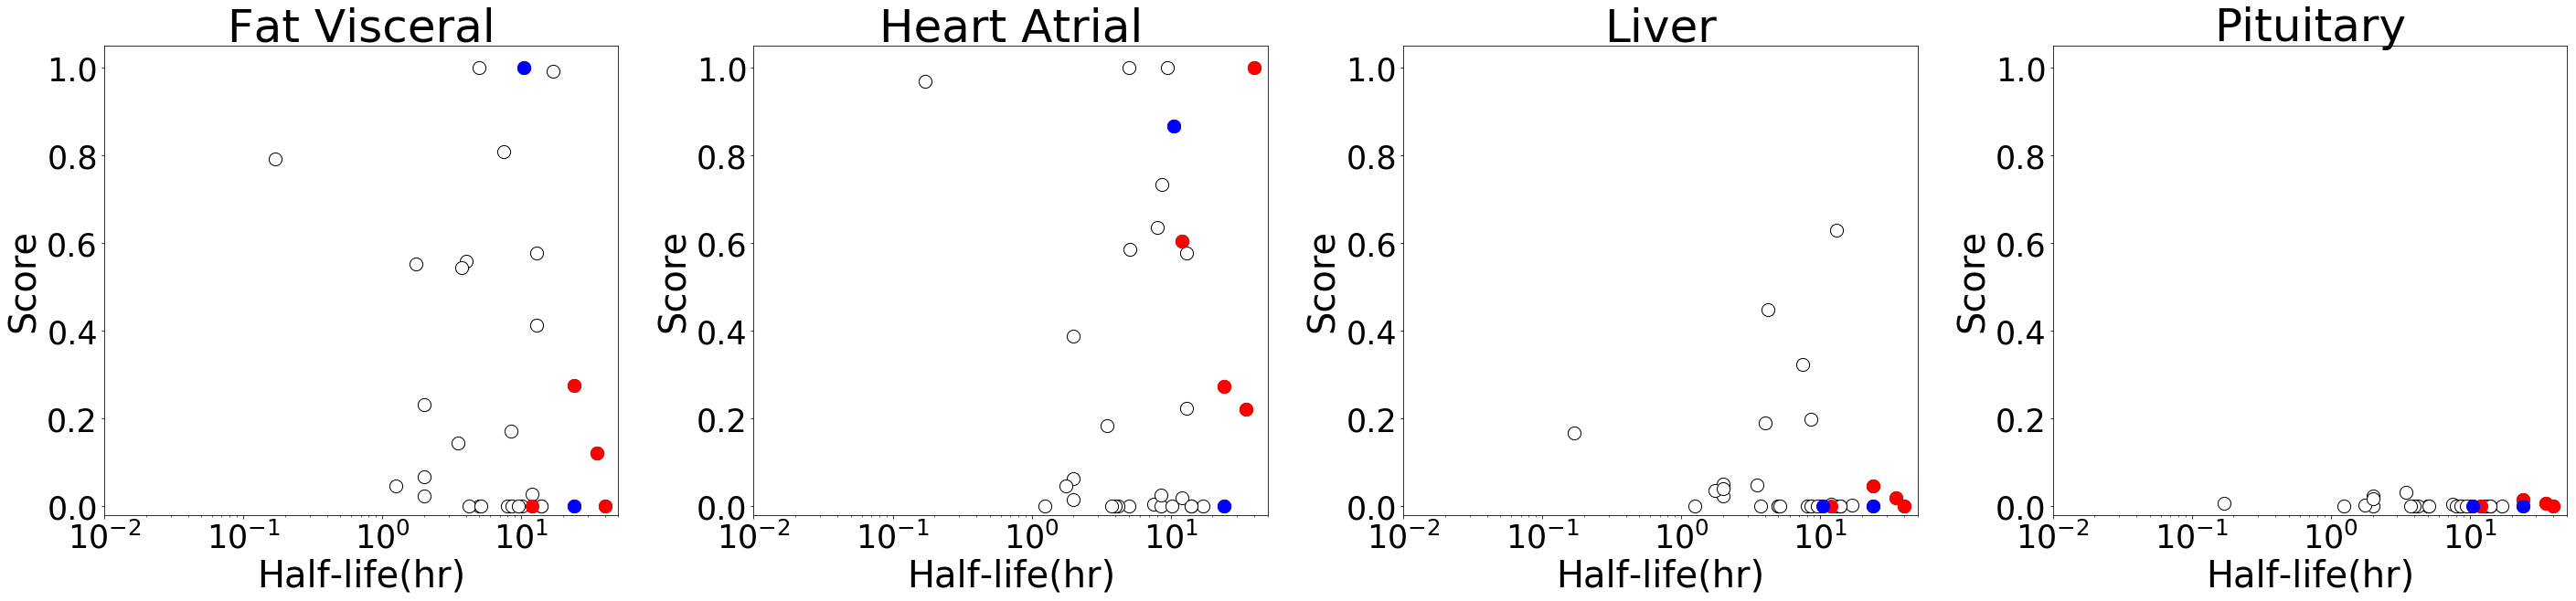

32

In [27]:
# hypertension
plt.figure(figsize = (40,10))
sns.despine(left = True)
plt.rc('font', size = 35)
plt.rc('axes', titlesize = 35)
plt.rc('axes', labelsize = 35)
plt.rc('xtick', labelsize = 35)
plt.rc('ytick', labelsize = 35)
plt.rc('legend', fontsize = 25)

plot_tissues = ['Fat\nVisceral','Heart\nAtrial','Liver','Pituitary']
plot_tissue_names = ['Fat Visceral','Heart Atrial','Liver','Pituitary']
hypertension_df = visuallize_disease_score(score_df, ruben_score_df, 'DOID:10763', plot_tissues, plot_tissue_names,
                        'plot/edge_circa_score_halflife_hypertension.pdf')
len(hypertension_df)

In [28]:
hypertension_df

,compound_id,disease_id,half_life_hours_curated,Aorta,Artery Coronary,Artery Tibial,Colon,Esophagus,Fat SQ,Fat Visceral,Heart Atrial,Liver,Lung,Nerve Tibial,Pituitary,Thyroid,Metapath cout,Path cout
27,DB01054,DOID:10763,12.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6052,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,12.0
28,DB00178,DOID:10763,24.00,0.0267,0.2452,0.0466,0.0356,0.1857,0.0602,0.2747,0.2726,0.0454,0.0853,0.0741,0.0139,0.0723,3.0,140.0
29,DB00381,DOID:10763,40.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,6.0
30,DB00584,DOID:10763,35.00,0.0254,0.1661,0.1043,0.0055,0.1714,0.1578,0.1209,0.2217,0.0189,0.0690,0.2510,0.0069,0.0775,3.0,295.0
31,DB00542,DOID:10763,10.50,0.0000,0.0000,0.0000,0.0000,0.8666,0.0000,1.0000,0.8666,0.0000,0.0000,0.8666,0.0000,0.0000,3.0,9.0
37,DB00519,DOID:10763,24.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0,5.0
8,DB00594,DOID:10763,7.50,0.0000,0.0240,0.1285,0.0000,0.0000,0.0000,0.8080,0.0047,0.3237,0.0000,0.0010,0.0047,0.6634,6.0,52.0
18,DB00436,DOID:10763,8.50,0.0000,0.0000,0.0000,0.2641,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2641,0.0000,0.0000,5.0,15.0
40,DB00887,DOID:10763,1.25,0.0000,0.8489,0.0000,0.0000,0.9533,0.0467,0.0467,0.0000,0.0000,0.0000,0.8956,0.0000,0.0000,3.0,36.0
46,DB01197,DOID:10763,2.00,0.0000,0.0182,0.0443,0.0225,0.0366,0.0320,0.0677,0.0620,0.0498,0.0014,0.0607,0.0237,0.1087,6.0,107.0
